<a href="https://colab.research.google.com/github/Kambey-san/NNWs_Basic/blob/HW_lesson_06/HW_lesson_06_Task_1v1_0_clb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-a5lu1s_4
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-a5lu1s_4
  Resolved https://github.com/tensorflow/examples.git to commit 0bbf4fe43fbf41b7174b9ce4a64d69bd33aadd21
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1689703202.67065300351684276117070052891639684042406419745-py3-none-any.whl size=301554 sha256=a2a3c5d49946fa5f44fd5f2e916af9c85ddaf75a3a94b0fe7110d7dfdfd58362
  Stored in directory: /tmp/pip-ephem-wheel-cache-f2mvth50/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [7]:
import tensorflow as tf

In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt


import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

In [9]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [11]:
builder = tfds.builder('oxford_iiit_pet:3.2.0')

info = builder.info

print(info)

config = tfds.download.DownloadConfig(register_checksums = True)

builder.download_and_prepare(download_config=config)

dataset = builder.as_dataset()

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmpicf79i3qtfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

In [12]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, download=False)

In [13]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [14]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [15]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [16]:
TRAIN_LENGTH = info.splits['train'].num_examples

In [17]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [18]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [19]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [20]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

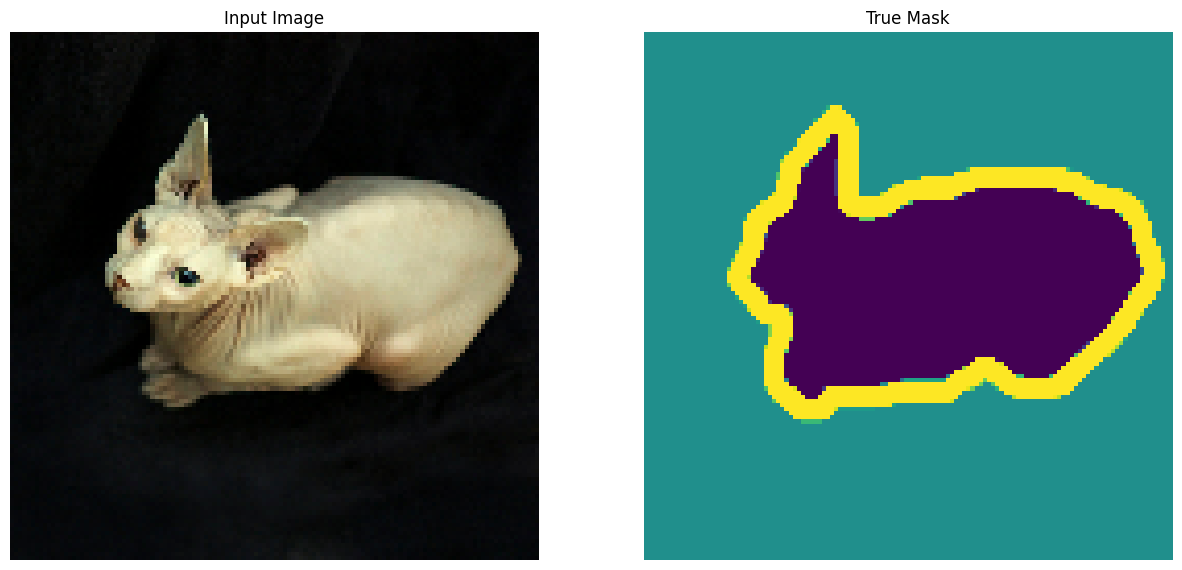

In [21]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [22]:
OUTPUT_CHANNELS = 3

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64x96
    'block_3_expand_relu',   # 32x32x144
    'block_6_expand_relu',   # 16x16x192
    'block_13_expand_relu',  # 8x8x576
    'block_16_project',      # 4x4x (block_16_project/Conv2D:0' shape=(None, 4, 4, 320))
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [24]:
[layer.output for layer in base_model.layers]

[<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'Conv1')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'bn_Conv1')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'Conv1_relu')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'expanded_conv_depthwise')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'expanded_conv_depthwise_BN')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'expanded_conv_depthwise_relu')>,
 <KerasTensor: shape=(None, 64, 64, 16) dtype=float32 (created by layer 'expanded_conv_project')>,
 <KerasTensor: shape=(None, 64, 64, 16) dtype=float32 (created by layer 'expanded_conv_project_BN')>,
 <KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'block_1_expand')>,
 <KerasTensor: shape=(None, 64, 64, 96) dtype=float32

In [25]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [26]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [27]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [29]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [30]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 1s 1s/step


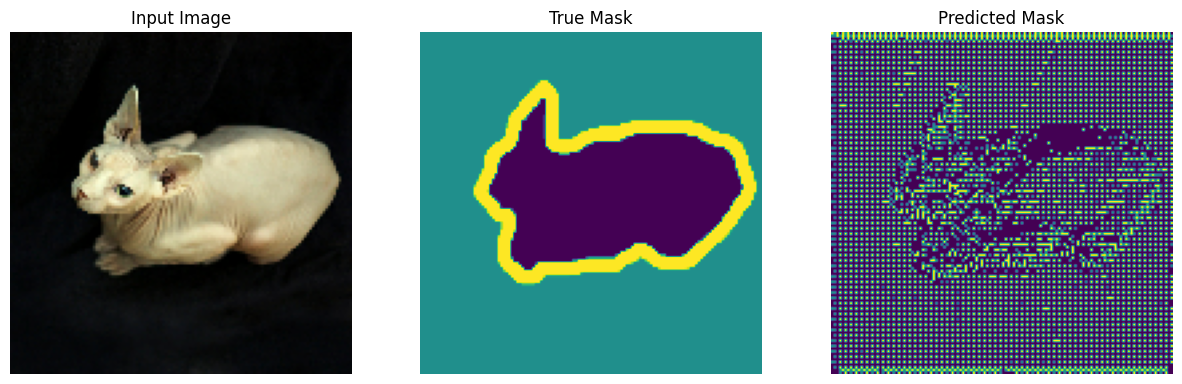

In [31]:
show_predictions()

 Обучим исходную модель MobileNetV2 на 10 эпохах

1/1 [==============================] - 0s 51ms/step


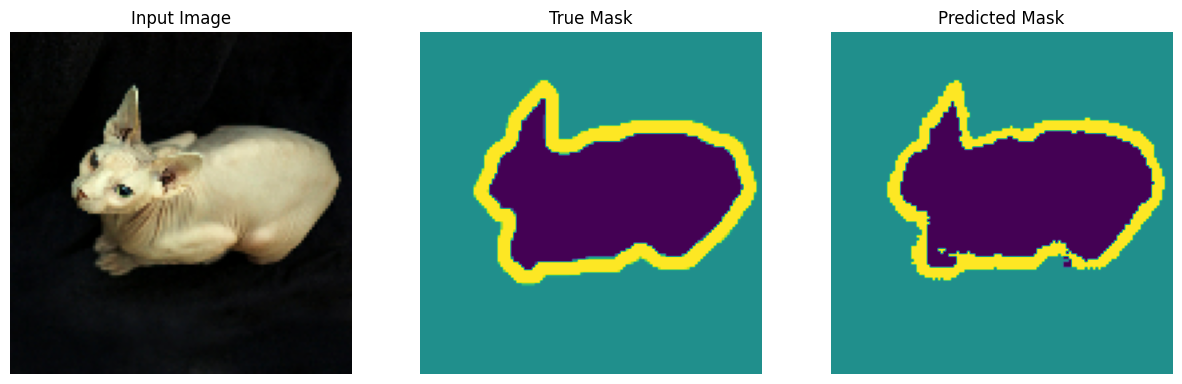


Sample Prediction after epoch 10

115/115 [==============================] - 240s 2s/step - loss: 0.2032 - accuracy: 0.9112 - val_loss: 0.2741 - val_accuracy: 0.8915
CPU times: user 59min 36s, sys: 7min 24s, total: 1h 7min
Wall time: 42min 25s


In [32]:
%%time
tf.random.set_seed(48)
EPOCHS = 10 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Рассмотрим предыдущую модификацию MobileNet. Сначала определим слои которые нам нужны

In [33]:
base_model = tf.keras.applications.MobileNet(input_shape=[128, 128, 3], include_top=False)

17225924/17225924 [==============================] - 2s 0us/step


In [34]:
[layer.output for layer in base_model.layers]

[<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'conv1')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'conv1_bn')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'conv1_relu')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'conv_dw_1')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'conv_dw_1_bn')>,
 <KerasTensor: shape=(None, 64, 64, 32) dtype=float32 (created by layer 'conv_dw_1_relu')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'conv_pw_1')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'conv_pw_1_bn')>,
 <KerasTensor: shape=(None, 64, 64, 64) dtype=float32 (created by layer 'conv_pw_1_relu')>,
 <KerasTensor: shape=(None, 65, 65, 64) dtype=float32 (created by layer 'conv_pad_2')>,
 <KerasTensor: shape=(None, 32,

In [35]:
base_model = tf.keras.applications.MobileNet(input_shape=[128, 128, 3], include_top=False)

In [36]:
# Use the activations of these layers
layer_names = [
    'conv_pw_1_relu',   # 64x64 (conv_pw_1_relu/Relu6:0' shape=(None, 64, 64, 64))
    'conv_pw_2_relu',   # 32x32 (conv_pw_2_relu/Relu6:0' shape=(None, 32, 32, 128))
    'conv_pw_4_relu',   # 16x16 (conv_pw_4_relu/Relu6:0' shape=(None, 16, 16, 256))
    'conv_pw_6_relu',   # 8x8 (conv_pw_6_relu/Relu6:0' shape=(None, 8, 8, 512))
    'conv_pw_13',       # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

1/1 [==============================] - 0s 74ms/step


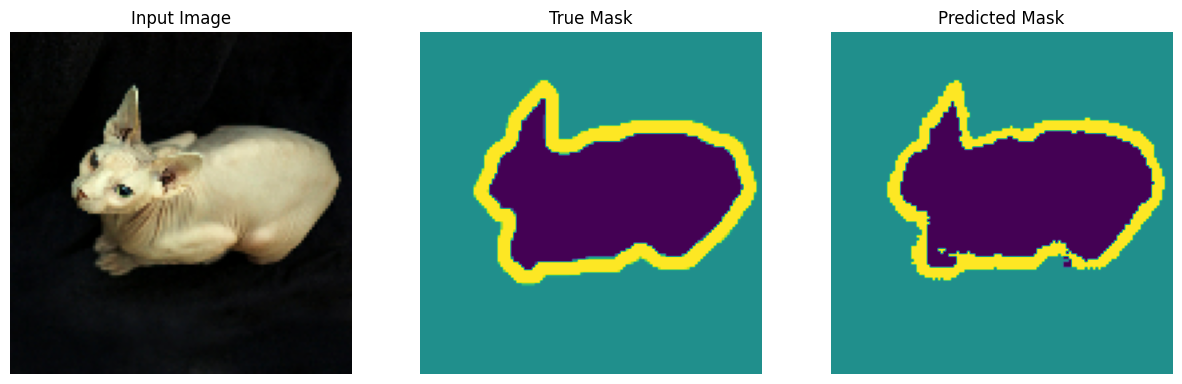

In [37]:
show_predictions()

Так же обучим на 10 эпохах

1/1 [==============================] - 0s 50ms/step


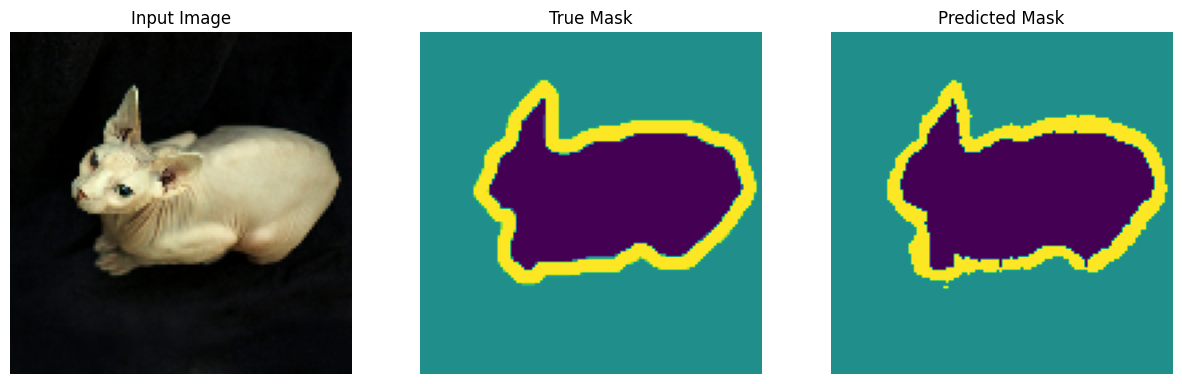


Sample Prediction after epoch 10

115/115 [==============================] - 242s 2s/step - loss: 0.1253 - accuracy: 0.9421 - val_loss: 0.3491 - val_accuracy: 0.8912
CPU times: user 59min 9s, sys: 7min 4s, total: 1h 6min 13s
Wall time: 41min 46s


In [38]:
%%time
tf.random.set_seed(48)
EPOCHS = 10 # увеличьте при необходимости
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

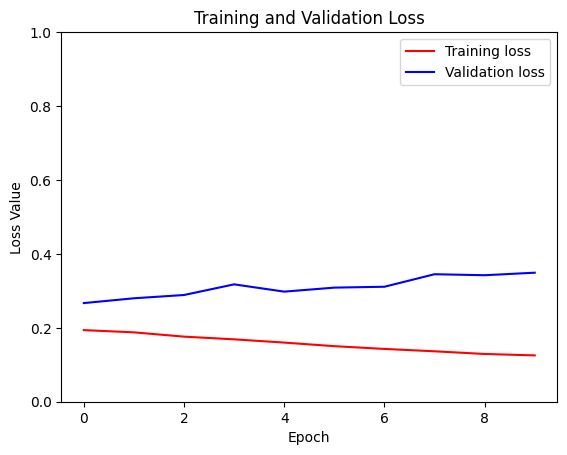

In [40]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step


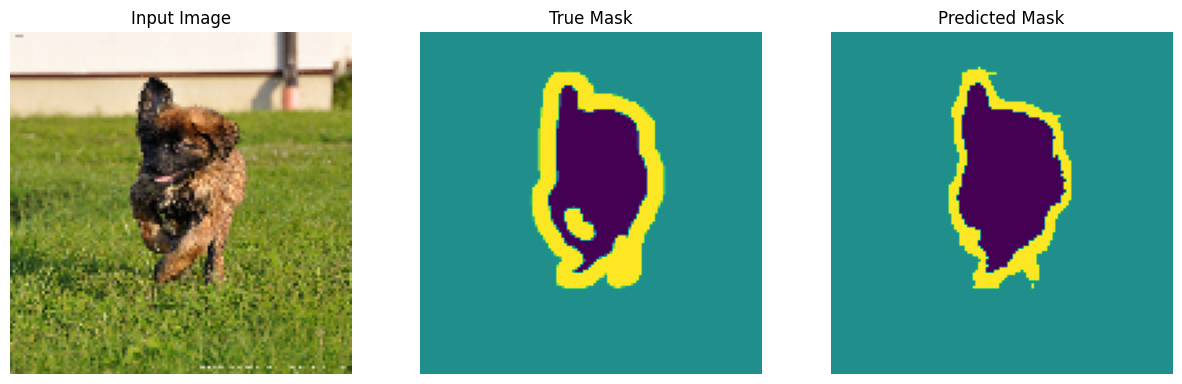

1/1 [==============================] - 1s 875ms/step


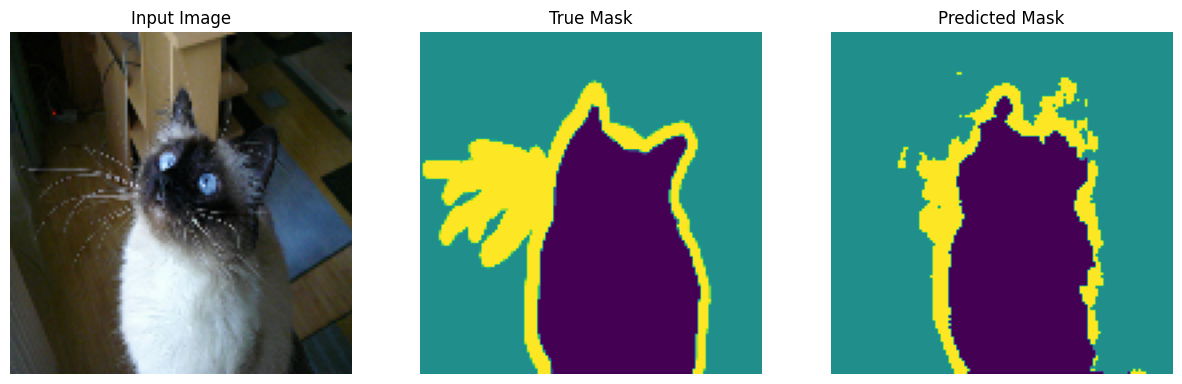

1/1 [==============================] - 1s 832ms/step


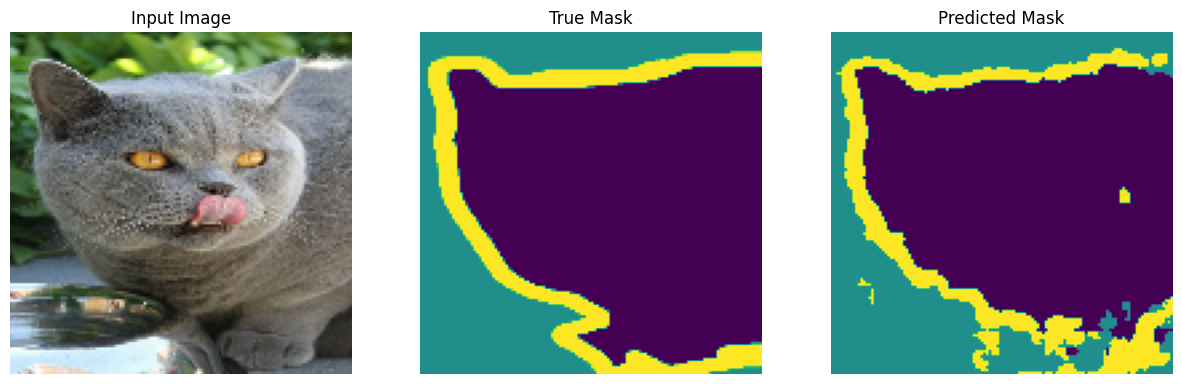

In [41]:
show_predictions(test_dataset, 3)

**Вывод:** при сравнения версий MobileNetV2 и MobileNet видно, что первая версия MobileNet оказалась менее точной чем вторая.